# Alternative Estimators for Lead Lag

We generate as with the toy Bachelier Model, two Brownian motions

In [276]:
import numpy as np

samples = 1000
maturity = 1
rho = 0.8
lag = 0.4555 # lag, set outside range 0.4 for extreme value fitting 

x_0 = 0
sigma_1 = 1  

y_0 = 0
sigma_2 = 1


time_steps = 10000
time_between_observations = 0.001

max_k = int(maturity / time_between_observations)

print(max_k)
observation_step = int(time_between_observations * time_steps/maturity)

# Function to generate a brownian motion
def generate_brownian(time_steps, samples, maturity):
    """
    # Generates 'samples' number of brownian motions up to time maturity, with total number of time steps time_steps

    Returns a samples by time_steps vector of samples brownian motions up to maturity.
    """

    sample_paths = np.zeros((time_steps, samples))

    sample_paths[1::] = np.sqrt(maturity/time_steps) * np.random.normal(0, 1, size = (time_steps - 1, samples))

    sample_paths = np.cumsum(sample_paths, axis = 0)
    
    return sample_paths


1000


In [277]:
def lagged_Bachelier_coupled_processes(time_steps, samples, maturity, rho, x_0, y_0, sigma_1, sigma_2, lag):
    """
    # Generates 'samples' number of coupled Bachelier processes, the second with lag 'lag', up to time maturity, with total number of time steps time_steps

    Returns two samples by time_steps vector of the Bachelier Processes up to maturity.
    Unlagged_X, Lagged_Y
    Unlagged_X being a Bachelier process with starting at x_0, volatility x_0
    With Lagged_Y having correlation rho, with X (after removing lag), lag 'lag', starting at y_0 with volatility sigma_2
    """
    # We double the maturity and number of time steps, since we want to take values of k up to maturity (and so we nececessarily need twice as many values)
    new_maturity = maturity * 2
    new_time_steps = time_steps * 2

    ## Calculate the number of time_steps to delay by
    time_step_lag = int(lag / new_maturity * new_time_steps)


    # We generate slightly longer sequences than the new maturity. Specifically longer by the lag, as we are going to truncate by the lag.
    brownians_1 = generate_brownian(new_time_steps + time_step_lag, samples, new_maturity*(new_time_steps + time_step_lag)/time_steps)

    independent_brownians = generate_brownian(new_time_steps + time_step_lag, samples, new_maturity*(new_time_steps + time_step_lag)/time_steps)

    # Create correlated brownians
    brownians_2 = rho * brownians_1 + np.sqrt(1-rho*rho) * independent_brownians


    # Create Ytilde_t and X_t
    Unlagged_X = x_0 + sigma_1 * brownians_1

    Ytilde = y_0 + sigma_2 * brownians_2

    # Truncate by the lag to obtain the sequence
    Lagged_Y = Ytilde[:-time_step_lag:]

    # We also truncate X at the end so the lengths match

    Unlagged_X = Unlagged_X[time_step_lag::]

    return Unlagged_X, Lagged_Y

Unlagged_X, Lagged_Y = lagged_Bachelier_coupled_processes(time_steps, samples, maturity, rho, x_0, y_0, sigma_1, sigma_2, lag)

print(Unlagged_X)
print(Lagged_Y)



[[-0.83923583 -1.16015656  0.55994384 ... -0.63648409  0.27854951
   0.1249847 ]
 [-0.83186261 -1.13392926  0.55665853 ... -0.63969086  0.29260613
   0.12590133]
 [-0.81698427 -1.13828353  0.57080662 ... -0.64069899  0.28482523
   0.10186312]
 ...
 [-0.12646028 -1.65978607 -1.24113722 ...  1.7137968   1.46447128
   1.74353806]
 [-0.11768926 -1.65253988 -1.22978815 ...  1.72459012  1.45384448
   1.7516506 ]
 [-0.12594228 -1.65316199 -1.22592391 ...  1.72027961  1.45999249
   1.73168147]]
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.01853239  0.01076524  0.01070487 ...  0.0022606  -0.00948948
   0.00923993]
 [-0.00185728 -0.01326156  0.01093228 ...  0.01346957 -0.01954624
   0.00931484]
 ...
 [-1.18049072 -0.49664533 -1.07111142 ... -0.13904581  0.00307567
   1.71849103]
 [-1.18942055 -0.50308599 -1.08064947 ... -0.15080755  0.01467619
   1.73829237]
 [-1.20832277 -0.49495313 -1.09538138 ... -0.16428744  0.01044726
   1.74015526]]


In [278]:
## Scaling appears to be off... but I am not going to trace this bug for now since this is a bit of a toy model
def autovariation(bachelier_1, bachelier_2, k, observation_step, max_k):
    """
    Returns the auto_variation of the two bachelier models for value k, assuming that observations are at constant intervals
    bachelier_1, the first underlying process
    bachelier_2, the second underlying process
    k, the autovariation evaluated at k (in multiples of the observation step) 
    observation_step, the gap between observations in the time series
    
    """

    delta_x_i = (bachelier_1[0:(max_k-1)*observation_step:observation_step] - bachelier_1[observation_step:max_k*observation_step:observation_step])
    
    
    delta_of_y_i_plus_k = (bachelier_2[k*observation_step:(max_k -1 +k)*observation_step:observation_step] - bachelier_2[(k+1)*observation_step:(max_k +k)*observation_step:observation_step])

    return np.sum(delta_x_i * delta_of_y_i_plus_k, axis = 0)


#print(autovariation(Unlagged_X, Lagged_Y, 13, observation_step, maturity, time_steps))




In [279]:
def get_autovariations(Unlagged_X, Lagged_Y, max_k, observation_step):
    variations = np.zeros((max_k, Unlagged_X.shape[1]))
    
    for k in range(1, max_k):
        variations[k] = autovariation(Unlagged_X, Lagged_Y, k, observation_step, max_k)

    return variations

autovariations = get_autovariations(Unlagged_X, Lagged_Y, max_k, observation_step)
print(autovariations)



[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.02674919  0.05591845  0.04586865 ...  0.05128831 -0.06462506
   0.05849472]
 [-0.01805878  0.01759778 -0.05855215 ...  0.0617675  -0.03689611
  -0.07676138]
 ...
 [ 0.05484681 -0.01531881 -0.09774094 ...  0.015987   -0.16093949
  -0.06991634]
 [-0.07019702 -0.05590968  0.1002302  ... -0.04206605 -0.05250819
  -0.0454574 ]
 [ 0.10969017  0.03005467 -0.09701537 ... -0.06644864  0.01731423
   0.01579198]]


In [280]:
# def stacked_autovariation(bachelier_1, bachelier_2, k, observation_step, max_k):
#     """
#     Returns the auto_variation of the two bachelier models for value k, assuming that observations are at constant intervals
#     bachelier_1, the first underlying process
#     bachelier_2, the second underlying process
#     k, the autovariation evaluated at k (in multiples of the observation step) 
#     observation_step, the gap between observations in the time series
    
#     """

#     x_i_minus_1 = bachelier_1[observation_step*2:(max_k-3)*observation_step:observation_step]
                 
#     x_i =  bachelier_1[observation_step*3:(max_k-2)*observation_step:observation_step]
    
#     y_i_plus_1 = bachelier_2[observation_step*(k+4):(max_k-1+k)*observation_step:observation_step]

#     y_i_plus_2 = bachelier_2[observation_step*(k+5):(max_k+k)*observation_step:observation_step]

#     y_i_minus_1 = bachelier_2[observation_step*(k+2):(max_k-3+k)*observation_step:observation_step]

#     y_i_minus_2  = bachelier_2[observation_step*(k+1):(max_k-4+k)*observation_step:observation_step]

#     return np.sum((x_i - x_i_minus_1)*(y_i_plus_2 + y_i_plus_1 - y_i_minus_1 - y_i_minus_2), axis = 0)


# # Staggered autovariations
# def get_stacked_autovariations(Unlagged_X, Lagged_Y, max_k, observation_step):
#     variations = np.zeros((max_k, Unlagged_X.shape[1]))
    
#     for k in range(1, max_k):
#         variations[k] = stacked_autovariation(Unlagged_X, Lagged_Y, k, observation_step, max_k)

#     return variations

# stacked_autovariations = get_stacked_autovariations(Unlagged_X, Lagged_Y, max_k, observation_step)
# print(stacked_autovariations)



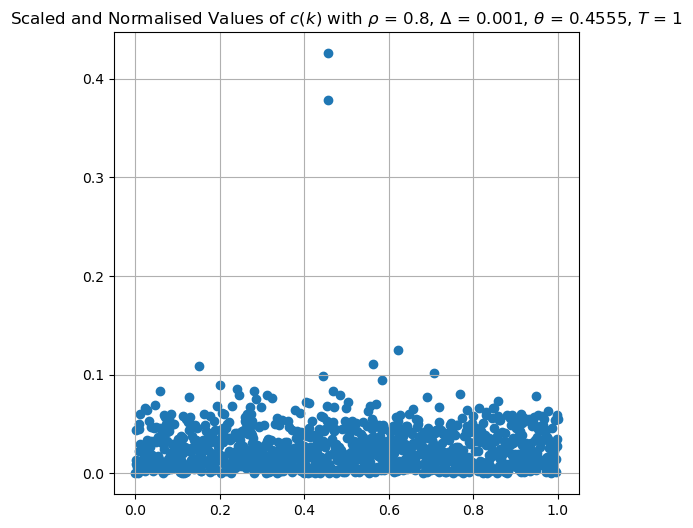

In [281]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams['text.usetex'] = False
x = np.linspace(0, maturity, max_k)
plt.scatter(x, np.abs(autovariations[:, 0])/2)
plt.title("Scaled and Normalised Values of $c(k)$ with $\\rho$ = " + str(rho) + ', $\\Delta$ = ' + str(time_between_observations) + ', $\\theta$ = '+str(lag)+', $T$ = '+str(maturity))
plt.grid()
plt.savefig('autovariation.eps', format='eps')
plt.show()




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


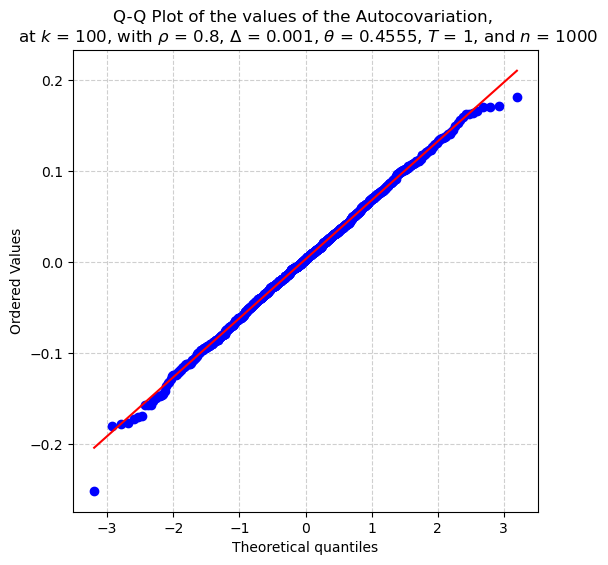

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


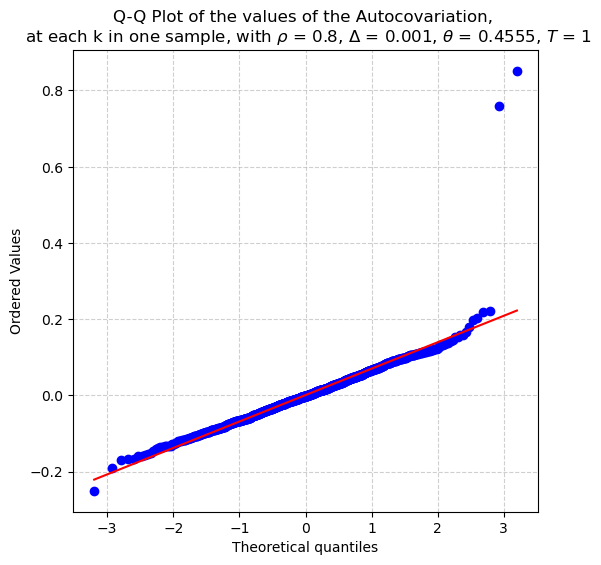

In [282]:
# We'll try a QQ plot after normalising the autovariations by their mean and variance
import numpy as np
import scipy.stats as stats

# The path of the warrior: Generate some data (normally distributed)
data = autovariations[100, :]
# The way of Bushidō: Create Q-Q plot
fig, ax = plt.subplots()
stats.probplot(data, dist="norm", plot=ax)

# A warrior's honor: Titles and grid
ax.set_title('Q-Q Plot of the values of the Autocovariation, \n at $k$ = 100, with $\\rho$ = ' + str(rho) + ', $\\Delta$ = ' + str(time_between_observations) + ', $\\theta$ = '+str(lag)+', $T$ = '+str(maturity) + ', and $n$ = ' + str(samples))
ax.grid(True, linestyle="--", alpha=0.6)

# Display the path of righteousness
plt.savefig('qq_plot.eps', format='eps')
plt.show()


# This is kind of expected
# Although not independent they have correlation zero with each other
# So each individual item is expected to be approximately a normal distribution by the CLT
# Especially if we have more samples

data = autovariations[:, 0]
# The way of Bushidō: Create Q-Q plot
fig, ax = plt.subplots()
stats.probplot(data, dist="norm", plot=ax)

# A warrior's honor: Titles and grid
ax.set_title('Q-Q Plot of the values of the Autocovariation, \n at each k in one sample, with $\\rho$ = ' + str(rho) + ', $\\Delta$ = ' + str(time_between_observations) + ', $\\theta$ = '+str(lag)+', $T$ = '+str(maturity))
ax.grid(True, linestyle="--", alpha=0.6)

# Display the path of righteousness
plt.savefig('qq_sample_plot.eps', format='eps')
plt.show()


In [283]:
# So as we can see from the above, the c(k) essentially have a normal distribution
# So we can characterise the extreme value distribution (which characterises the distribution of the maxima) as part of the Gumbel distribution

In [284]:
# We want to identify the distribution of the zero mean c(k). They are the sum of n products of two normal distributions. So dividing by n, we might expect the CLT to apply. 
# To check this assumption we'll try to plot the distribution of a c(k)

In [285]:
# import scipy.stats as stats

# data = autovariations[0, :]

# # Fit a normal distribution to check fit
# mu, std = stats.norm.fit(data)

# plt.hist(data, density = True)

# xmin, xmax = plt.xlim()

# x = np.linspace(xmin, xmax, 100)
# pdf = stats.norm.pdf(x, mu, std)

# plt.plot(x, pdf, 'r', linewidth=2)


# plt.show()

In [286]:
# ### We want to find the extreme value distribution for the c(k). Although they're not independently distributed, their correlation is mostly zero. 
# # So we will try to find the value of eta, parameterising the GEV, using the mean excess function and maximum liklihood estimation.

# data = autovariations[:, 0] # Want to calculate the extreme value distribution
# data = np.abs(data)

# print(data)

In [287]:
# # First define the mean excess function
# def mean_excess(v ,data):
#     print(np.maximum(data -v, 0).sum())
#     print((np.maximum(data -v, 0) > 0).sum())
#     return np.maximum(data -v, 0).sum() / (np.maximum(data -v, 0) > 0).sum()

# print(mean_excess(0, data))

In [288]:
# # Now check where the mean excess function becomes linear

# plot_points = 100
# v = np.linspace(0, 1, plot_points)
# excess = np.zeros(plot_points)
# for i in range(plot_points):
#     excess[i] = mean_excess(v[i], data)

# plt.plot(v, excess)
# plt.show()


In [289]:
# u = 0 # Looks fine

# # log liklihood of exceedances over the found threshold parameter u
# # define for each exceedance Y_i = X_i - u
# # beta > 0
# # - {no_of_exceedances}* log(beta)- sum_j^{no_of_exceedances}log(1 + xi * Y_i/beta)
# # Constraint on beta, xi so that 1 + Y_i *xi/beta > 0 for all i
# # I.e. Y_i * xi > - beta
# # I.e. Since the Y_i are always positive, we take the max Y_i
# # max(Y_i) * xi > -beta 
# # If beta is more negative than this we reset beta

# def GEV_log_liklihood(xi, beta, data, u):
#     N_u = (np.maximum(data - u,0) > 0).sum()# no of exceedances

#     beta = np.max((-np.max((data - u)), beta))

#     return -N_u * np.log(beta) - (1 + 1/xi) * (np.log(1 + np.maximum(data - u, 0) * xi/beta)).sum()

# print(GEV_log_liklihood(0.5, 0.5, data, 0))

In [290]:
# def minus_wrapped_liklihood(x_0):
#     xi = x_0[0]
#     beta = x_0[1]
#     return -GEV_log_liklihood(xi, beta, data, u)

# from scipy.optimize import minimize
# x_0 = np.array([0.5,0.5])
# params = minimize(minus_wrapped_liklihood, x_0)

# print(params)

In [291]:
def original_estimator(autovariations, maturity, time_steps, observation_step):
    return np.argmax(np.abs(autovariations), axis = 0) * maturity/time_steps * observation_step




def weighted_original_estimator(autovariations, maturity, time_steps, observation_step):
    index_estimates = np.argmax(np.abs(autovariations), axis = 0)
    estimates = np.zeros(index_estimates.shape)
    
    # If the index is zero, or at the end, it's a teensy bit hard to decide what to do, so we just return the original estimate. And these are edge cases so we ignore for now
    sample = 0
    for index in index_estimates:
        if index == 0 or index == autovariations.shape[0] - 1:
            estimates[sample] = index * maturity/time_steps * observation_step
        else:# Take a weighted average based on the adjacent item with the next highest index
            if autovariations[index-1, sample] > autovariations[index+1,sample]:
                estimates[sample] = ((index - 1) * autovariations[index-1, sample] + index * autovariations[index, sample]) / (autovariations[index, sample] + autovariations[index-1, sample]) * maturity/time_steps * observation_step
            else:
                estimates[sample] = ((index + 1) * autovariations[index+1, sample] + index * autovariations[index, sample]) / (autovariations[index, sample] + autovariations[index+1, sample]) * maturity/time_steps * observation_step
        
        # Increment the sample we perform this for
        sample += 1
    
    return estimates

print(weighted_original_estimator(autovariations, maturity, time_steps, observation_step))






[0.45552913 0.45549435 0.45554257 0.45544092 0.45551039 0.45548064
 0.4555057  0.4555034  0.4554609  0.4555108  0.45549971 0.45555577
 0.45548934 0.45548541 0.45550057 0.45550765 0.45550405 0.45552861
 0.45550734 0.45548268 0.45546689 0.45548139 0.45550975 0.45554507
 0.45550558 0.4555016  0.45549257 0.4555073  0.45549613 0.45547951
 0.45553436 0.45548513 0.45555632 0.45551954 0.45551586 0.45552061
 0.45551898 0.45551584 0.45552695 0.45551479 0.45550901 0.45549089
 0.4554967  0.45550182 0.45553514 0.45549452 0.45549686 0.45549826
 0.45548113 0.45552311 0.45556448 0.45550503 0.45552514 0.45546855
 0.45551135 0.45548082 0.45550339 0.45552126 0.45549553 0.45547109
 0.45552975 0.45547733 0.45551564 0.45548149 0.45550161 0.45548784
 0.45551032 0.45548209 0.45551871 0.45554075 0.45549477 0.45553347
 0.45549527 0.45554    0.45548154 0.45552255 0.45550173 0.45551801
 0.45550471 0.45554532 0.45548304 0.45556323 0.45548509 0.45549464
 0.45551661 0.45550159 0.45543846 0.45549371 0.45550077 0.4554

In [292]:
import pandas as pd

# The idea with this estimator is to smooth out some of the random variation by taking a rolling sum. 
# The correlation should bias the autocorrelation in one direction around the true lag value of k, even for small correlations, whereas the other values are expected to be centred around zero.
# Therefore the hope is that by doing a rolling sum, a stronger signal for the lag can be detected, by averaging out the random variations in the other values for k

def rolling_sum_estimator(autovariations, maturity, time_steps, observation_step, rolling_step):
    temp_df = pd.DataFrame(autovariations)
    # I want to do a rolling sum here... convolve doesn't work because of the dimension, so we'll cast it to pandas
    rolled_autovariations = temp_df.rolling(rolling_step, axis = 0).sum().fillna(0).values

    # print(autovariations)
    # print(rolled_autovariations)

    # Truncating to ensure that we have the shape we want
    rolled_autovariations = rolled_autovariations[:autovariations.shape[0],:autovariations.shape[1]]

    # print(rolled_autovariations)

    # Apply the original estimator (probably need to do a shift)

    return original_estimator(rolled_autovariations, maturity, time_steps, observation_step) - observation_step / time_steps


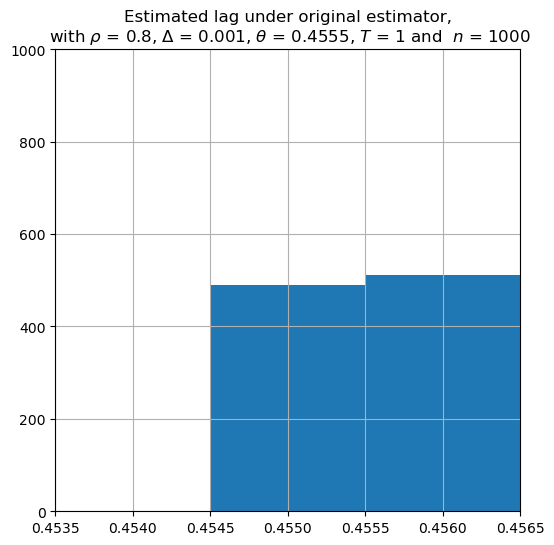

Number of times each value was obtained under original estimator
{0.45499999999999996: 489, 0.456: 511}


C:\Users\rapto\AppData\Local\Temp\ipykernel_50244\2873705753.py:10: FutureWarning: The 'axis' keyword in DataFrame.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  rolled_autovariations = temp_df.rolling(rolling_step, axis = 0).sum().fillna(0).values


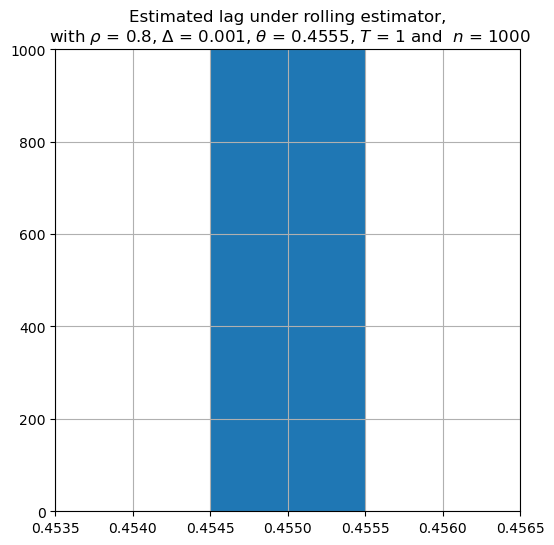

Number of times each value was obtained under rolling estimator of length 2
{0.455: 1000}


In [293]:
## We will now count the number of times the original estimator correctly estimated in this case
estimates = original_estimator(autovariations, maturity, time_steps, observation_step)

# plt.hist(estimates, bins = samples)
# plt.title("Original Estimator")
# plt.grid()
# plt.show()

values = {}

for estimate in estimates:
    values.setdefault(estimate, 0)
    values[estimate] += 1

values = dict(sorted(values.items()))

plt.rcParams["figure.figsize"] = (6,6)
plt.bar(values.keys(), values.values(), width = observation_step/time_steps)
plt.xlim(lag - observation_step/time_steps*2, lag + observation_step/time_steps*1)
plt.ylim(top = samples)
plt.title('Estimated lag under original estimator,\n with $\\rho$ = ' + str(rho) + ', $\\Delta$ = ' + str(time_between_observations) + ', $\\theta$ = '+str(lag)+', $T$ = '+str(maturity)+' and  $n$ = ' +str(samples))
plt.grid()
plt.savefig('original_bar_chart.eps', format='eps')
plt.show()


print("Number of times each value was obtained under original estimator")
print(values)

## Now for the rolling_sum estimator
rolling_estimates = rolling_sum_estimator(autovariations, maturity, time_steps, observation_step, 2)

# plt.hist(rolling_estimates, bins = samples)
# plt.title("Rolling Estimator")
# plt.grid()
# plt.show()

values = {}

for estimate in rolling_estimates:
    values.setdefault(estimate, 0)
    values[estimate] += 1

values = dict(sorted(values.items()))

plt.bar(values.keys(), values.values(), width = observation_step/time_steps)
plt.xlim(lag - observation_step/time_steps*2, lag + observation_step/time_steps*1)
plt.ylim(top = samples)
plt.title('Estimated lag under rolling estimator,\n with $\\rho$ = ' + str(rho) + ', $\\Delta$ = ' + str(time_between_observations) + ', $\\theta$ = '+str(lag)+', $T$ = '+str(maturity)+' and  $n$ = ' +str(samples))
plt.grid()
plt.savefig('rolling_bar_chart.eps', format='eps')
plt.show()


print("Number of times each value was obtained under rolling estimator of length 2")
print(values)

# ## Now for the rolling_sum estimator
# stacked_estimates = original_estimator(stacked_autovariations, maturity, time_steps, observation_step)

# plt.hist(stacked_estimates, bins = samples)
# plt.title("Stacked Estimator")
# plt.grid()
# plt.show()

# values = {}

# for estimate in stacked_estimates:
#     values.setdefault(estimate, 0)
#     values[estimate] += 1

# values = dict(sorted(values.items()))

# print("Number of times each value was obtained under stacked estimator")
# print(values)


C:\Users\rapto\AppData\Local\Temp\ipykernel_50244\2873705753.py:10: FutureWarning: The 'axis' keyword in DataFrame.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  rolled_autovariations = temp_df.rolling(rolling_step, axis = 0).sum().fillna(0).values


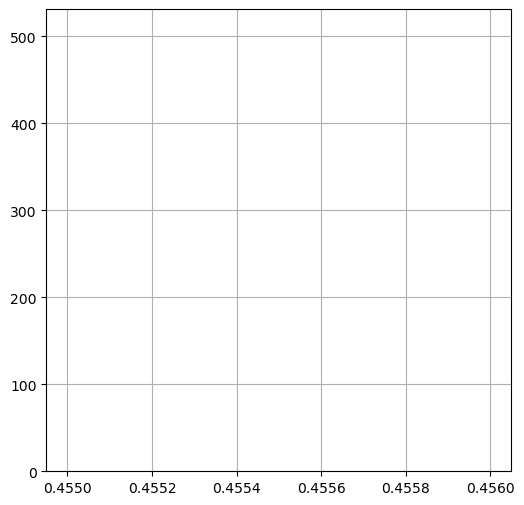

Number of times each value was obtained under rolling estimator of length 3
{0.455: 494, 0.45599999999999996: 506, 'bins': 1000}


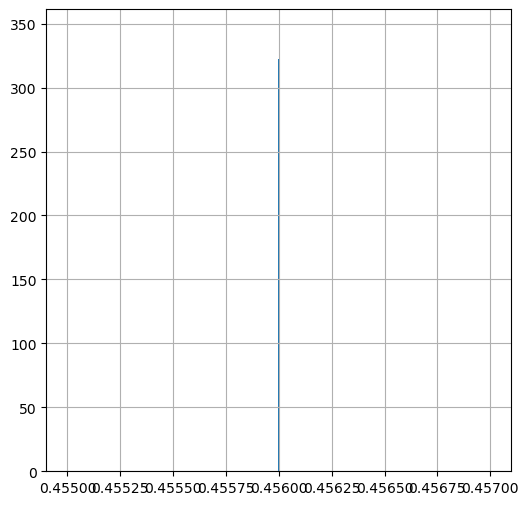

Number of times each value was obtained under rolling estimator of length 4
{0.455: 334, 0.45599999999999996: 322, 0.457: 344}


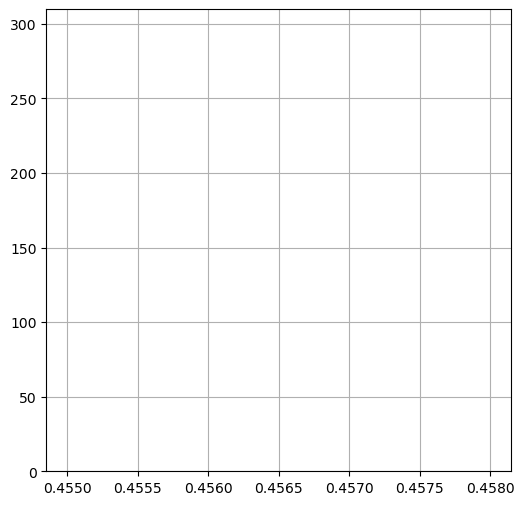

Number of times each value was obtained under rolling estimator of length 5
{0.455: 259, 0.45599999999999996: 232, 0.457: 214, 0.458: 295}


In [294]:

## Now for the rolling_sum estimator
rolling_estimates = rolling_sum_estimator(autovariations, maturity, time_steps, observation_step, 3)

plt.hist(rolling_estimates, bins = samples)
plt.grid()
plt.show()

values = {}

for estimate in rolling_estimates:
    values.setdefault(estimate, 0)
    values[estimate] += 1

values = dict(sorted(values.items()), bins = samples)

print("Number of times each value was obtained under rolling estimator of length 3")
print(values)

## Now for the rolling_sum estimator
rolling_estimates = rolling_sum_estimator(autovariations, maturity, time_steps, observation_step, 4)

plt.hist(rolling_estimates, bins = samples)
plt.grid()
plt.show()

values = {}

for estimate in rolling_estimates:
    values.setdefault(estimate, 0)
    values[estimate] += 1

values = dict(sorted(values.items()))

print("Number of times each value was obtained under rolling estimator of length 4")
print(values)

## Now for the rolling_sum estimator
rolling_estimates = rolling_sum_estimator(autovariations, maturity, time_steps, observation_step, 5)

plt.hist(rolling_estimates, bins = samples)
plt.grid()
plt.show()

values = {}

for estimate in rolling_estimates:
    values.setdefault(estimate, 0)
    values[estimate] += 1

values = dict(sorted(values.items()))

print("Number of times each value was obtained under rolling estimator of length 5")
print(values)